Line Modeling simulation with [PowerSimulationsDynamics.jl](https://github.com/NREL-SIIP/PowerSimulationsDynamics.jl)

**Originally Contributed by**: Rodrigo Henriquez and José Daniel Lara

## Introduction

This tutorial will introduce an example of considering dynamic lines in `PowerSimulationsDynamics`.
Note that this tutorial is for `PowerSimulationsDynamics`.

This tutorial presents a simulation of a three-bus system, with an infinite bus (represented as a
voltage source behind an impedance) at bus 1, a one d- one q- machine on bus 2 and an inverter
of 19 states, as a virtual synchronous machine at bus 3. The perturbation will be the trip of
two of the three circuits (triplicating its resistance and impedance) of the line that connects
bus 1 and bus 3. This case also consider a dynamic line model for connection between buses
2 and 3. We will compare it against a system without dynamic lines.

In addition, note that `PowerSimulationsDynamics` will convert ConstantPower loads to RLC
loads for transient simulations.

It is recommended to check `Tutorial 1: OMIB` first, since that includes more details and
explanations on all definitions and functions.

# Step 1: Package Initialization

In [1]:
using SIIPExamples
using PowerSimulationsDynamics
PSID = PowerSimulationsDynamics
using PowerSystems
using Sundials
using Plots

# Step 2: Data creation

In [2]:
file_dir = joinpath(
    dirname(dirname(pathof(SIIPExamples))),
    "script",
    "4_PowerSimulationsDynamics_examples",
    "Data",
)
threebus_sys = System(joinpath(file_dir, "threebus_sys.json"));

[ Info: Loaded time series from storage file existing=threebus_sys_time_series_storage.h5 new=/var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_uwlMCM
┌ Warning: Rate 250.0 MW for BUS 1-BUS 3-i_1 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148
┌ Warning: Rate 250.0 MW for BUS 1-BUS 2-i_2 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148
┌ Warning: Rate 250.0 MW for BUS 2-BUS 3-i_3 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148
┌ Warning: struct DynamicInverter does not exist in validation configuration file, validation skipped
└ @ InfrastructureSystems ~/.julia/packages/InfrastructureSystems/9N5Vj/src/validation.jl:51
┌ Warning: struct D

In addition, we will create a new copy of the system on which we will simulate the same
case, but will consider dynamic lines:

In [3]:
threebus_sys_dyn = deepcopy(threebus_sys);

[ Info: Serialized time series data to /var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_t6cuxV/sys_time_series_storage.h5.
[ Info: Serialized System to /var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_t6cuxV/sys.json
[ Info: Loaded time series from storage file existing=sys_time_series_storage.h5 new=/var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_KYFjnz
┌ Warning: Rate 250.0 MW for BUS 1-BUS 3-i_1 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148
┌ Warning: Rate 250.0 MW for BUS 1-BUS 2-i_2 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148
┌ Warning: Rate 250.0 MW for BUS 2-BUS 3-i_3 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148


# Step 3: Create the fault and simulation on the Static Lines system

First, we construct the perturbation, by properly computing the new Ybus on the system:

In [4]:
#Make a copy of the original system
sys2 = deepcopy(threebus_sys)
#Triplicates the impedance of the line named "BUS 1-BUS 3-i_1"
fault_branches = get_components(ACBranch, sys2)
for br in fault_branches
    if get_name(br) == "BUS 1-BUS 3-i_1"
        br.r = 3 * br.r
        br.x = 3 * br.x
        b_new = (from = br.b.from / 3, to = br.b.to / 3)
        br.b = b_new
    end
end
#Obtain the new Ybus
Ybus_fault = Ybus(sys2).data
#Define Fault: Change of YBus
Ybus_change = NetworkSwitch(
    1.0, #change at t = 1.0
    Ybus_fault, #New YBus
);

[ Info: Serialized time series data to /var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_RSsbmE/sys_time_series_storage.h5.
[ Info: Serialized System to /var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_RSsbmE/sys.json
[ Info: Loaded time series from storage file existing=sys_time_series_storage.h5 new=/var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_PtkYQZ
┌ Warning: Rate 250.0 MW for BUS 1-BUS 3-i_1 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148
┌ Warning: Rate 250.0 MW for BUS 1-BUS 2-i_2 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148
┌ Warning: Rate 250.0 MW for BUS 2-BUS 3-i_3 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148


Now, we construct the simulation:

In [5]:
#Time span of our simulation
tspan = (0.0, 30.0)

#Define Simulation
sim = PSID.Simulation(
    pwd(), #folder to output results
    threebus_sys, #system
    tspan, #time span
    Ybus_change, #Type of perturbation
)

[ Info: Serialized time series data to /var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_9Jqn3l/sys_time_series_storage.h5.
[ Info: Serialized System to /var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_9Jqn3l/sys.json
[ Info: Loaded time series from storage file existing=sys_time_series_storage.h5 new=/var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_2oBJzf
┌ Warning: Rate 250.0 MW for BUS 1-BUS 3-i_1 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148
┌ Warning: Rate 250.0 MW for BUS 1-BUS 2-i_2 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148
┌ Warning: Rate 250.0 MW for BUS 2-BUS 3-i_3 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148


Simulation()


We can obtain the initial conditions as:

In [6]:
#Will print the initial states. It also give the symbols used to describe those states.
print_device_states(sim)
#Will export a dictionary with the initial condition values to explore
x0_init = PSID.get_initial_conditions(sim)

Voltage Variables
BUS 1
Vm 1.02
θ -0.0
BUS 2
Vm 1.0142
θ -0.0247
BUS 3
Vm 1.0059
θ 0.05
Differential States
generator-102-1
eq_p 0.6478
ed_p 0.6672
δ 0.9386
ω 1.0
Vf 1.0781
Vr1 0.0333
Vr2 -0.1941
Vm 1.0142
Differential States
generator-103-1
ω_oc 1.0
θ_oc 0.4573
q_oc -0.4453
ξd_ic 0.0013
ξq_ic 0.0004
γd_ic 0.0615
γq_ic -0.0138
ϕd_ic 0.8765
ϕq_ic -0.1978
vd_pll 0.8986
vq_pll -0.0
ε_pll -0.0
θ_pll 0.2354
ir_cnv 0.7462
ii_cnv 0.757
vr_filter 0.8738
vi_filter 0.2095
ir_filter 0.7617
ii_filter 0.6923


Dict{String,Any} with 6 entries:
  "generator-102-1" => Dict(:Vf=>1.07808,:Vr2=>-0.194055,:ed_p=>0.667241,:ω=>1.…
  "V_R"             => Dict(102=>1.01389,103=>1.00464,101=>1.02)
  "Vm"              => Dict(102=>1.0142,103=>1.0059,101=>1.02)
  "θ"               => Dict(102=>-0.0247452,103=>0.0500046,101=>-8.28357e-14)
  "V_I"             => Dict(102=>-0.0250941,103=>0.0502787,101=>-8.44924e-14)
  "generator-103-1" => Dict(:vi_filter=>0.209533,:γd_ic=>0.0615061,:vq_pll=>-6.…

# Step 4: Run the simulation of the Static Lines System

In [7]:
#Run the simulation
PSID.execute!(
    sim, #simulation structure
    IDA(), #Sundials DAE Solver
    dtmax = 0.02, #Maximum step size
)

# Step 5: Store the solution

In [8]:
series2 = get_voltagemag_series(sim, 102)
zoom = [
    (series2[1][ix], series2[2][ix]) for
    (ix, s) in enumerate(series2[1]) if (s > 0.90 && s < 1.6)
];

# Step 3.1: Create the fault and simulation on the Dynamic Lines system

An important aspect to consider is that DynamicLines must not be considered in the computation of the Ybus. First we construct the Dynamic Line, by finding the Line named "BUS 2-BUS 3-i_3", and then adding it to the system.

get component return the Branch on threebus_sys_dyn named "BUS 2-BUS 3-i_3"

In [9]:
dyn_branch = DynamicBranch(get_component(Branch, threebus_sys_dyn, "BUS 2-BUS 3-i_3"))


BUS 2-BUS 3-i_3 (PowerSystems.DynamicBranch):
   branch: BUS 2-BUS 3-i_3 (PowerSystems.Line)
   n_states: 2
   states: [:Il_R, :Il_I]
   internal: InfrastructureSystems.InfrastructureSystemsInternal

Adding a dynamic line will inmediately remove the static line from the system.

In [10]:
add_component!(threebus_sys_dyn, dyn_branch)

┌ Warning: struct DynamicBranch does not exist in validation configuration file, validation skipped
└ @ InfrastructureSystems ~/.julia/packages/InfrastructureSystems/9N5Vj/src/validation.jl:51


Similarly, we construct the Ybus fault by creating a copy of the original system, but
removing the Line "BUS 2-BUS 3-i_3" to avoid considering it in the Ybus:

In [11]:
#Make a copy of the original system
sys3 = deepcopy(threebus_sys);
#Remove Line "BUS 2-BUS 3-i_3"
remove_component!(Line, sys3, "BUS 2-BUS 3-i_3")
#Triplicates the impedance of the line named "BUS 1-BUS 2-i_1"
fault_branches2 = get_components(Line, sys3)
for br in fault_branches2
    if get_name(br) == "BUS 1-BUS 3-i_1"
        br.r = 3 * br.r
        br.x = 3 * br.x
        b_new = (from = br.b.from / 3, to = br.b.to / 3)
        br.b = b_new
    end
end
#Obtain the new Ybus
Ybus_fault_dyn = Ybus(sys3).data
#Define Fault: Change of YBus
Ybus_change_dyn = PowerSimulationsDynamics.NetworkSwitch(
    1.0, #change at t = 1.0
    Ybus_fault_dyn, #New YBus
)

[ Info: Serialized time series data to /var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_AQIjGW/sys_time_series_storage.h5.
[ Info: Serialized System to /var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_AQIjGW/sys.json
[ Info: Loaded time series from storage file existing=sys_time_series_storage.h5 new=/var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_fdS3yR
┌ Warning: Rate 250.0 MW for BUS 1-BUS 3-i_1 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148
┌ Warning: Rate 250.0 MW for BUS 1-BUS 2-i_2 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148
┌ Warning: Rate 250.0 MW for BUS 2-BUS 3-i_3 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148


PowerSimulationsDynamics.NetworkSwitch(1.0, 
  [1, 1]  =  0.91954-10.9011im
  [2, 1]  =  -0.689655+8.27586im
  [3, 1]  =  -0.229885+2.75862im
  [1, 2]  =  -0.689655+8.27586im
  [2, 2]  =  0.689655-8.17586im
  [1, 3]  =  -0.229885+2.75862im
  [3, 3]  =  0.229885-2.72529im)

# Step 4.1: Run the simulation of the Dynamic Lines System

Now, we construct the simulation:

Time span of our simulation

In [12]:
tspan = (0.0, 30.0)

(0.0, 30.0)

Define Simulation

In [13]:
sim_dyn = PSID.Simulation(
    pwd(), #folder to output results
    threebus_sys_dyn, #system
    tspan, #time span
    Ybus_change_dyn, #Type of perturbation
)

[ Info: Serialized time series data to /var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_YDOaHw/sys_time_series_storage.h5.
[ Info: Serialized System to /var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_YDOaHw/sys.json
[ Info: Loaded time series from storage file existing=sys_time_series_storage.h5 new=/var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_k8Z8xu
┌ Warning: Rate 250.0 MW for BUS 1-BUS 3-i_1 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148
┌ Warning: Rate 250.0 MW for BUS 1-BUS 2-i_2 is larger than the max expected in the range of (min = 47.0, max = 52.0).
└ @ PowerSystems ~/.julia/packages/PowerSystems/4kGrw/src/utils/IO/branchdata_checks.jl:148
┌ Warning: struct DynamicBranch does not exist in validation configuration file, validation skipped
└ @ InfrastructureSystems ~/.julia/packages/InfrastructureSystems/9N5Vj/src/validation.jl:51
┌ Warning: struct 

Simulation()


Run the simulation

In [14]:
PSID.execute!(
    sim_dyn, #simulation structure
    IDA(), #Sundials DAE Solver
    dtmax = 0.02, #Maximum step size
)

We can obtain the initial conditions as:

In [15]:
#Will print the initial states. It also give the symbols used to describe those states.
print_device_states(sim_dyn)
#Will export a dictionary with the initial condition values to explore
x0_init_dyn = PSID.get_initial_conditions(sim_dyn)

Voltage Variables
BUS 1
Vm 1.02
θ -0.0
BUS 2
Vm 1.0142
θ -0.0247
BUS 3
Vm 1.0059
θ 0.05
Differential States
generator-102-1
eq_p 0.6478
ed_p 0.6672
δ 0.9386
ω 1.0
Vf 1.0781
Vr1 0.0333
Vr2 -0.1941
Vm 1.0142
Differential States
generator-103-1
ω_oc 1.0
θ_oc 0.4573
q_oc -0.4453
ξd_ic 0.0013
ξq_ic 0.0004
γd_ic 0.0615
γq_ic -0.0138
ϕd_ic 0.8765
ϕq_ic -0.1978
vd_pll 0.8986
vq_pll 0.0
ε_pll -0.0
θ_pll 0.2354
ir_cnv 0.7462
ii_cnv 0.757
vr_filter 0.8738
vi_filter 0.2095
ir_filter 0.7617
ii_filter 0.6923
Line Current States
Line BUS 2-BUS 3-i_3
Il_R -0.08348
Il_I -0.01213


Dict{String,Any} with 7 entries:
  "generator-102-1"      => Dict(:Vf=>1.07808,:Vr2=>-0.194055,:ed_p=>0.667241,:…
  "V_R"                  => Dict(102=>1.01389,103=>1.00464,101=>1.02)
  "Vm"                   => Dict(102=>1.0142,103=>1.0059,101=>1.02)
  "θ"                    => Dict(102=>-0.0247452,103=>0.0500046,101=>-8.28357e-…
  "V_I"                  => Dict(102=>-0.0250941,103=>0.0502787,101=>-8.44924e-…
  "generator-103-1"      => Dict(:vi_filter=>0.209533,:γd_ic=>0.0615061,:vq_pll…
  "Line BUS 2-BUS 3-i_3" => Dict(:Il_I=>-0.0121293,:Il_R=>-0.083478)

# Step 5.1: Store the solution

In [16]:
series2_dyn = get_voltagemag_series(sim_dyn, 102)
zoom_dyn = [
    (series2_dyn[1][ix], series2_dyn[2][ix]) for
    (ix, s) in enumerate(series2_dyn[1]) if (s > 0.90 && s < 1.6)
];

# Step 6.1: Compare the solutions:

We can observe the effect of Dynamic Lines

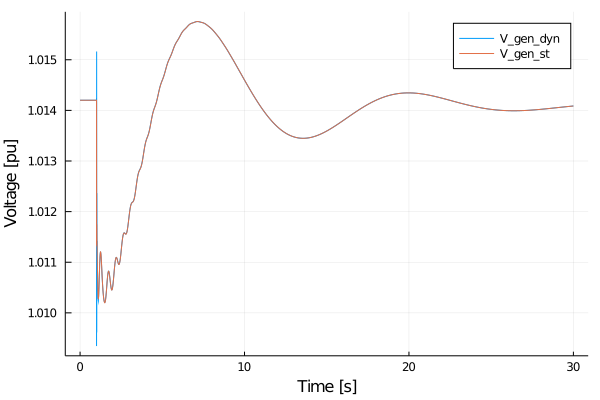

In [17]:
Plots.plot(series2_dyn, label = "V_gen_dyn")
Plots.plot!(series2, label = "V_gen_st", xlabel = "Time [s]", ylabel = "Voltage [pu]")

that looks quite similar. The differences can be observed in the zoom plot:

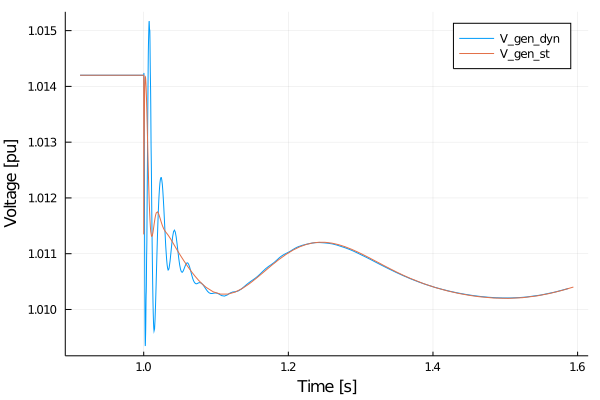

In [18]:
Plots.plot(zoom_dyn, label = "V_gen_dyn")
Plots.plot!(zoom, label = "V_gen_st", xlabel = "Time [s]", ylabel = "Voltage [pu]")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*